Chargement du fichier CSV...


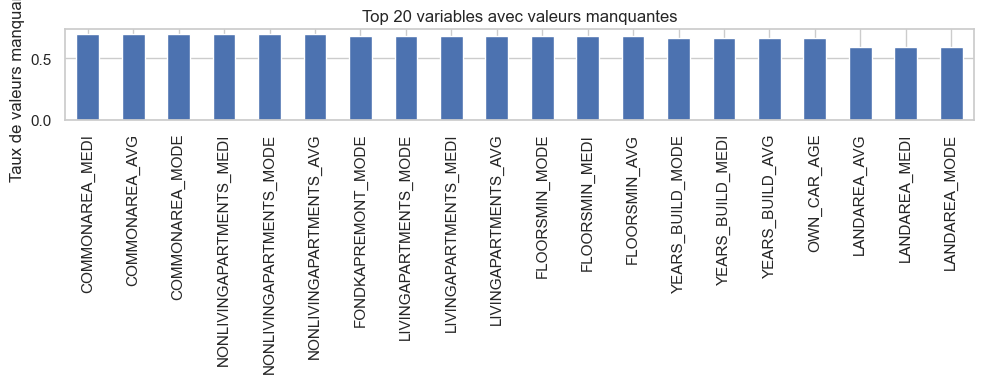

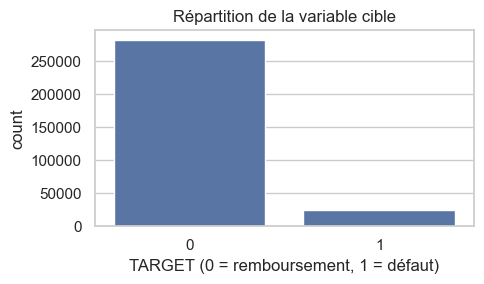

Dimensions des données : Train = (246008, 171), Test = (61503, 171)

--- Entraînement du modèle : Logistic Regression ---
AUC : 0.7453
Kappa : 0.1463
Matrice de confusion :
 [[38961 17577]
 [ 1631  3334]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503


--- Entraînement du modèle : Random Forest ---
AUC : 0.7375
Kappa : 0.1697
Matrice de confusion :
 [[43517 13021]
 [ 2137  2828]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     56538
           1       0.18      0.57      0.27      4965

    accuracy                           0.75     61503
   macro avg       0.57      0.67      0.56     61503
weighte

C:\Users\Edris.paikan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:04:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC : 0.7501
Kappa : 0.2191
Matrice de confusion :
 [[51452  5086]
 [ 3247  1718]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     56538
           1       0.25      0.35      0.29      4965

    accuracy                           0.86     61503
   macro avg       0.60      0.63      0.61     61503
weighted avg       0.89      0.86      0.87     61503


>>> Modèle sélectionné : XGBoost (AUC = 0.7501)
Modèle sauvegardé sous 'model.pkl'


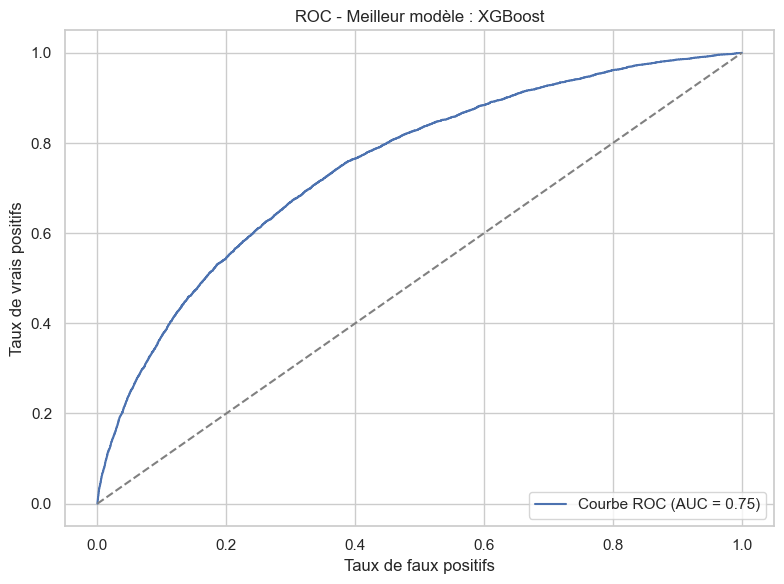

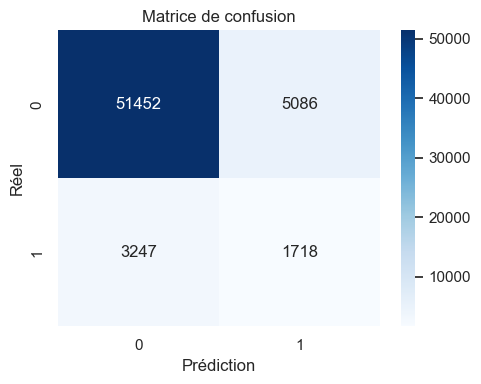

In [1]:
# === ÉTUDE DE CAS - SCORING PRÊT CLIENT ===
# Objectif : Implémentation experte en Python du scoring d'éligibilité au prêt pour une néo-banque
# Données : application_train.csv (provenant du challenge Kaggle Home Credit Default Risk)
# Étapes : préparation des données, modélisation, évaluation, visualisation, export

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, cohen_kappa_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC  # Désactivé : SVM trop lent sur gros dataset
from xgboost import XGBClassifier

# Configuration globale pour une meilleure lisibilité des graphiques
RANDOM_STATE = 42
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# -------------------------------------------------------------------
# ÉTAPE 1 - CHARGEMENT ET NETTOYAGE DES DONNÉES
# -------------------------------------------------------------------
print("Chargement du fichier CSV...")
data = pd.read_csv("application_train.csv")

# Échantillonnage pour accélérer l'entraînement pendant le développement
# data = data.sample(n=30000, random_state=42)

# Suppression de l'identifiant client (non pertinent pour le modèle)
data.drop(columns=['SK_ID_CURR'], inplace=True)

# Analyse du taux de valeurs manquantes
missing_ratio = data.isnull().mean()
plt.figure(figsize=(10, 4))
missing_ratio[missing_ratio > 0].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 variables avec valeurs manquantes")
plt.ylabel("Taux de valeurs manquantes")
plt.tight_layout()
plt.show()

# Suppression des colonnes avec plus de 40% de valeurs manquantes
data = data.loc[:, missing_ratio < 0.4]

# Remplissage des valeurs manquantes restantes pour les colonnes numériques
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Encodage one-hot des variables catégorielles
data = pd.get_dummies(data, drop_first=True)

# -------------------------------------------------------------------
# ÉTAPE 2 - SÉPARATION EN VARIABLES EXPLICATIVES ET CIBLE
# -------------------------------------------------------------------
X = data.drop("TARGET", axis=1)
y = data["TARGET"]

# Répartition de la cible
plt.figure(figsize=(5, 3))
sns.countplot(x=y)
plt.title("Répartition de la variable cible")
plt.xlabel("TARGET (0 = remboursement, 1 = défaut)")
plt.tight_layout()
plt.show()

# Split des données en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train.to_csv("X_train_used.csv", index=False)

print(f"Dimensions des données : Train = {X_train.shape}, Test = {X_test.shape}")

# -------------------------------------------------------------------
# ÉTAPE 3 - DÉFINITION ET ENTRAÎNEMENT DES MODÈLES
# -------------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=RANDOM_STATE),
    # "SVM (linéaire)": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    # Le modèle SVM a été désactivé car il est très lent à l'entraînement sur des datasets volumineux.
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5, random_state=RANDOM_STATE)
}

results = {}
best_model = None
best_score = 0

# Boucle d'entraînement et d'évaluation des modèles
for name, model in models.items():
    print(f"\n--- Entraînement du modèle : {name} ---")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Scores
    auc_score = roc_auc_score(y_test, y_proba)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Affichage des métriques clés
    print(f"AUC : {auc_score:.4f}")
    print(f"Kappa : {kappa:.4f}")
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Rapport de classification :\n", classification_report(y_test, y_pred))

    # Sauvegarde des performances
    results[name] = {'model': pipeline, 'auc': auc_score, 'proba': y_proba}

    if auc_score > best_score:
        best_score = auc_score
        best_model = pipeline
        best_name = name
        best_proba = y_proba
        best_pred = y_pred

# -------------------------------------------------------------------
# ÉTAPE 4 - VISUALISATION DU MEILLEUR MODÈLE
# -------------------------------------------------------------------
print(f"\n>>> Modèle sélectionné : {best_name} (AUC = {best_score:.4f})")

# Sauvegarde du modèle pour déploiement
joblib.dump(best_model, "model.pkl")
print("Modèle sauvegardé sous 'model.pkl'")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title(f'ROC - Meilleur modèle : {best_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Matrice de confusion en heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, best_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()